In [37]:
import project_path
import os
import json

from lib.mr.run_independent_partitions import RunIndependentPartitions
from lib.mr.change_qubit_order import ChangeQubitOrder
from lib.utils import load_config_and_check
from lib.qmt import execute_programs

from lib.detectors import KS_Detector
from lib.inspector import OneNightStandInspector
from lib.utils import load_config_and_check

from termcolor import colored
import ast


# reload libraries
%reload_ext autoreload
%autoreload 2

# Parameters

In [16]:
qdiff_path = "../warnings/sample_distribution_differences/qdiff"
morphq_path = "../warnings/sample_distribution_differences/morphq"

In [43]:
from json import JSONDecodeError


def rerun_and_plot(bug_folder: str, exp_name: str):
    """Rerun the given source and followup programs and compare the results."""
    exp_config = load_config_and_check(
        os.path.join("../config/", f"{exp_name}.yaml"))
    metadata_filename = [
        f for f in os.listdir(bug_folder) 
        if f.startswith("metadata") and not f.startswith("metadata_exec_")][0]
    metadata_filepath = os.path.join(bug_folder, metadata_filename)
    metadata = json.load(open(metadata_filepath, 'r'))
    source_filename = [
        f for f in os.listdir(bug_folder) if f.startswith("source")][0]
    source_filepath = os.path.join(bug_folder, source_filename)
    followup_filename = [
        f for f in os.listdir(bug_folder) if f.startswith("followup")][0]
    followup_filepath = os.path.join(bug_folder, followup_filename)

    base_name = os.path.basename(bug_folder)
    print(f"PROGRAM_ID_UNDER_ANALYSIS: {base_name}")
    RES = execute_programs(
        metadata_source = {"py_file_path": source_filepath},
        metadata_followup = {"py_file_path": followup_filepath})
    print(metadata["followup"]["metamorphic_transformations"])

    transformations = metadata["followup"]["metamorphic_transformations"]

    if "RunIndependentPartitions" in transformations:
        idx_run_indep_part_mr = metadata["followup"]["metamorphic_transformations"].index("RunIndependentPartitions")
        mr = RunIndependentPartitions(
            name="RunIndependentPartitions",
            metamorphic_strategies_config=exp_config["morphq_metamorphic_strategies"],
            detectors_config=exp_config["detectors"]
        )
        mapping_str_to_int = metadata["followup"]["metamorphic_info"][str(idx_run_indep_part_mr)]["mapping"]
        mapping_int_to_int = {
            int(k): int(v) for k, v in mapping_str_to_int.items()
        }
        mr.full_mapping = mapping_int_to_int
        print(mr.full_mapping)    
        print(type(mr.full_mapping))
        reduced = mr._reconstruct(RES["res_B"])
        reduced = {k: round(v / 8000) for k, v in reduced.items()}
        RES["res_B"] = reduced
    elif "ChangeQubitOrder" in transformations:
        idx_change_qubit_order = metadata["followup"]["metamorphic_transformations"].index("ChangeQubitOrder")
        mr = ChangeQubitOrder(
            name="ChangeQubitOrder",
            metamorphic_strategies_config=exp_config["morphq_metamorphic_strategies"],
            detectors_config=exp_config["detectors"]
        )
        mapping_str_to_int = metadata["followup"]["metamorphic_info"][str(idx_change_qubit_order)]["mapping"]
        print(mapping_str_to_int)    
        print(type(mapping_str_to_int))
        if isinstance(mapping_str_to_int, str):
            try:
                mapping_str_to_int = json.loads(mapping_str_to_int)
            except JSONDecodeError:
                mapping_str_to_int = ast.literal_eval(mapping_str_to_int)
        mapping_int_to_int = {
            int(k): int(v) for k, v in mapping_str_to_int.items()
        }
        n_idx = int(metadata["source"]["n_qubits"])
        mr.full_mapping = {**mapping_int_to_int, **{
            i: i for i in range(n_idx) if i not in mapping_int_to_int.keys()}}
        RES["res_B"] = {
            mr._read_str_with_mapping(bitstring, mr.full_mapping): freq
            for bitstring, freq in RES["res_B"].items()
        }
    detector = KS_Detector()
    _, pval = detector.check(RES["res_A"], RES["res_B"])
    if pval <= 0.05:
        print(colored("DIFFERENT", "red"))
    else:
        print(colored("SAME RESULT (p_val > 0.5)", "green"))
    print(f"New p-value: {pval}")
    OneNightStandInspector(dict(RES["res_A"]), dict(RES["res_B"]))

# QDiff

PROGRAM_ID_UNDER_ANALYSIS: 52_520491
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeBackend']
SAME RESULT (p_val > 0.5)
New p-value: 0.22230191274568828
n_qubits: 8
n_shots_platform_a: 2771.0
n_shots_platform_b: 2771.0
Uniform threshold: 0.00390625


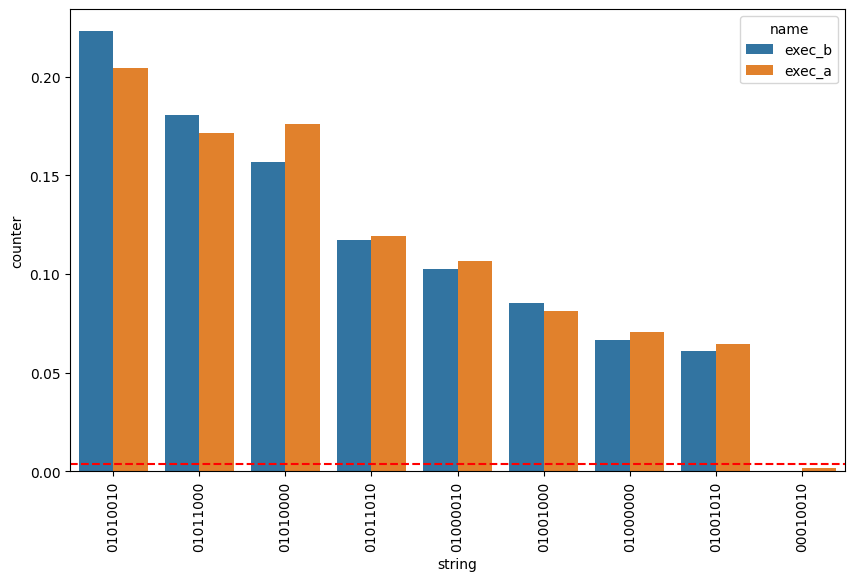

PROGRAM_ID_UNDER_ANALYSIS: 52_cb82e8
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeBackend']
SAME RESULT (p_val > 0.5)
New p-value: 0.9658712100698157
n_qubits: 9
n_shots_platform_a: 3919.0
n_shots_platform_b: 3919.0
Uniform threshold: 0.001953125


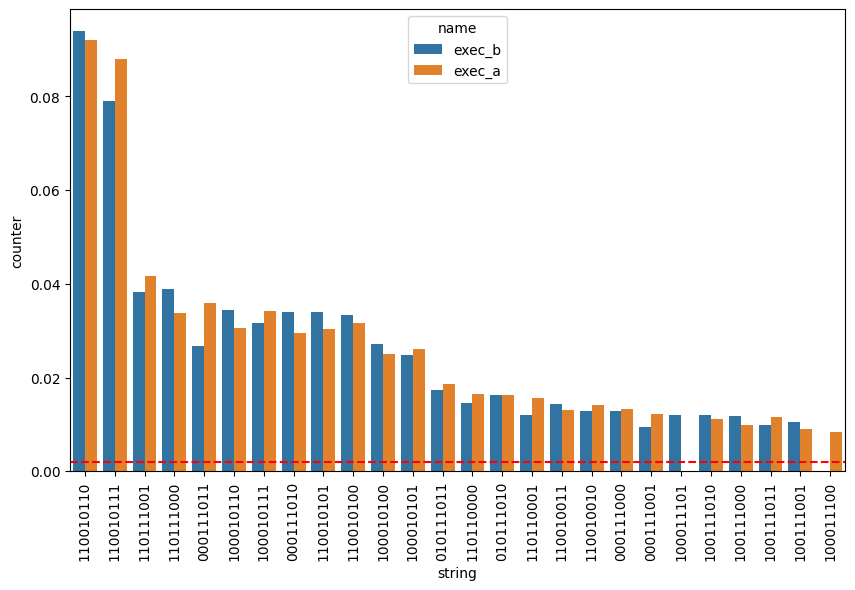

PROGRAM_ID_UNDER_ANALYSIS: 52_404403
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeOptLevel']
SAME RESULT (p_val > 0.5)
New p-value: 0.6009506833126489
n_qubits: 8
n_shots_platform_a: 2771.0
n_shots_platform_b: 2771.0
Uniform threshold: 0.00390625


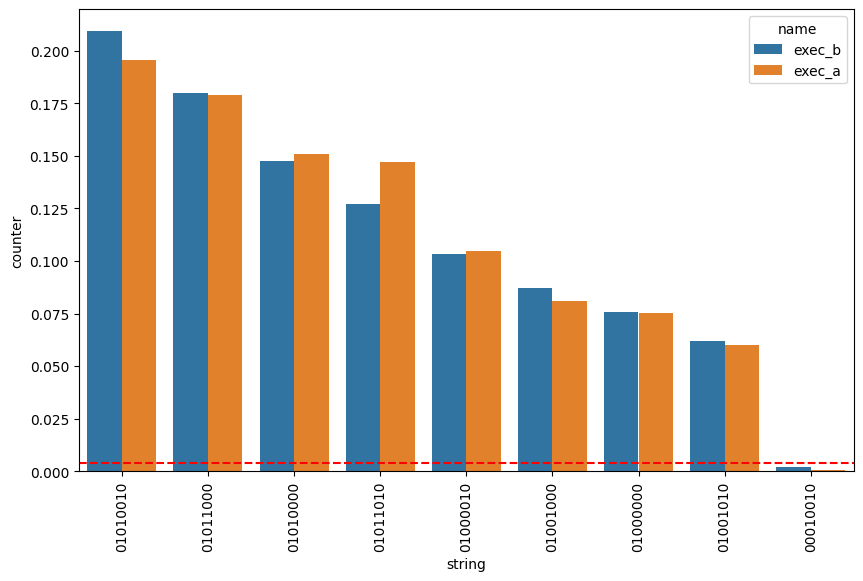

PROGRAM_ID_UNDER_ANALYSIS: 52_a4eafb
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeBackend']
SAME RESULT (p_val > 0.5)
New p-value: 0.8786704237758675
n_qubits: 10
n_shots_platform_a: 5542.0
n_shots_platform_b: 5542.0
Uniform threshold: 0.0009765625


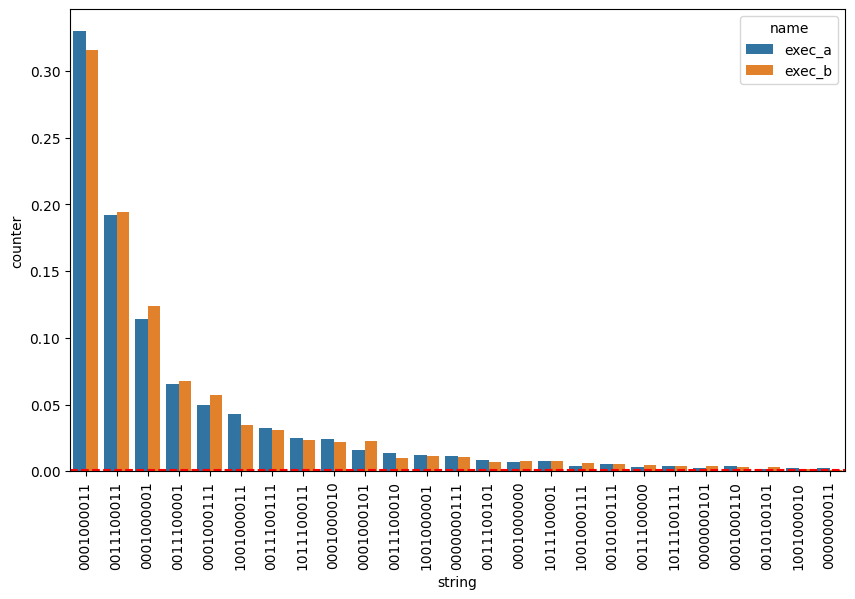

PROGRAM_ID_UNDER_ANALYSIS: 52_4cfe2e
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG4ZtoSS', 'ChangeOptLevel']
SAME RESULT (p_val > 0.5)
New p-value: 0.9999939877861364
n_qubits: 4
n_shots_platform_a: 692.0
n_shots_platform_b: 692.0
Uniform threshold: 0.0625


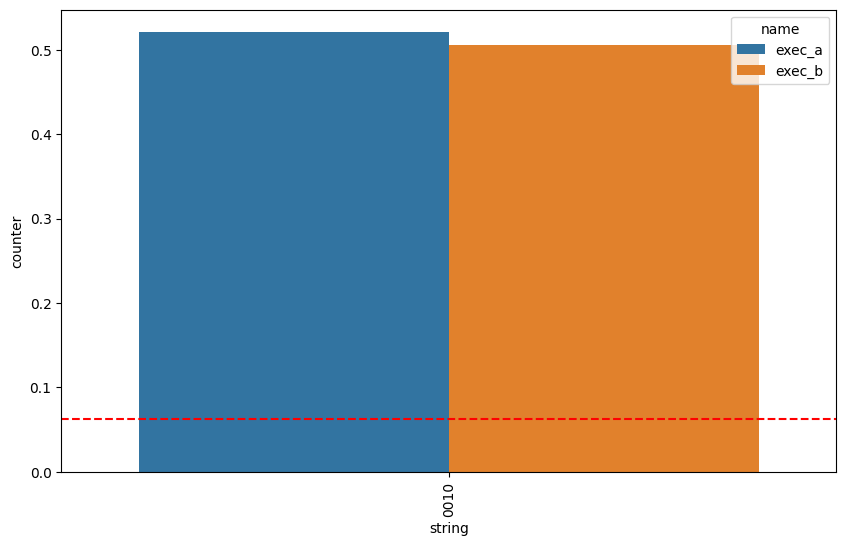

PROGRAM_ID_UNDER_ANALYSIS: 52_c7b35f
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeOptLevel']
SAME RESULT (p_val > 0.5)
New p-value: 0.4194888675499031
n_qubits: 9
n_shots_platform_a: 3919.0
n_shots_platform_b: 3919.0
Uniform threshold: 0.001953125


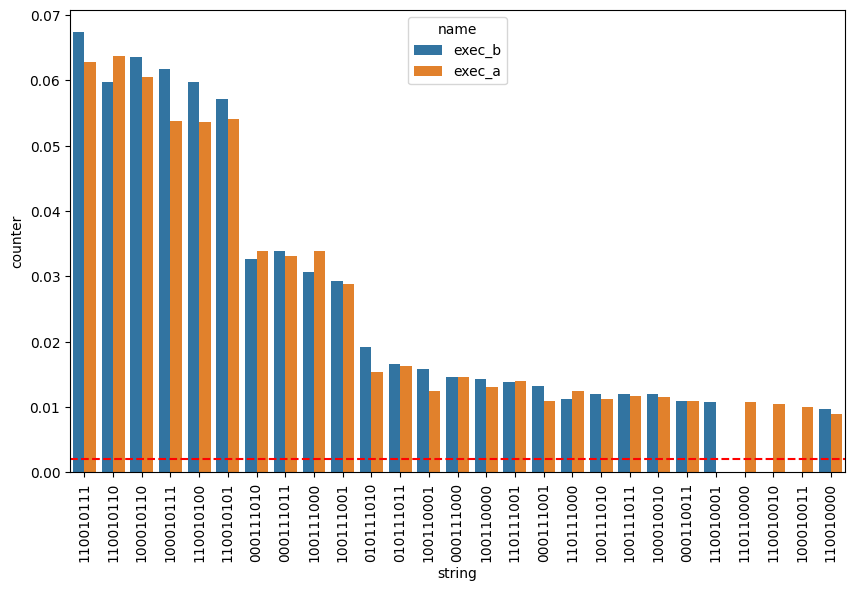

PROGRAM_ID_UNDER_ANALYSIS: 52_960f30
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeBackend']
SAME RESULT (p_val > 0.5)
New p-value: 0.8759554665249341
n_qubits: 11
n_shots_platform_a: 7838.0
n_shots_platform_b: 7838.0
Uniform threshold: 0.00048828125


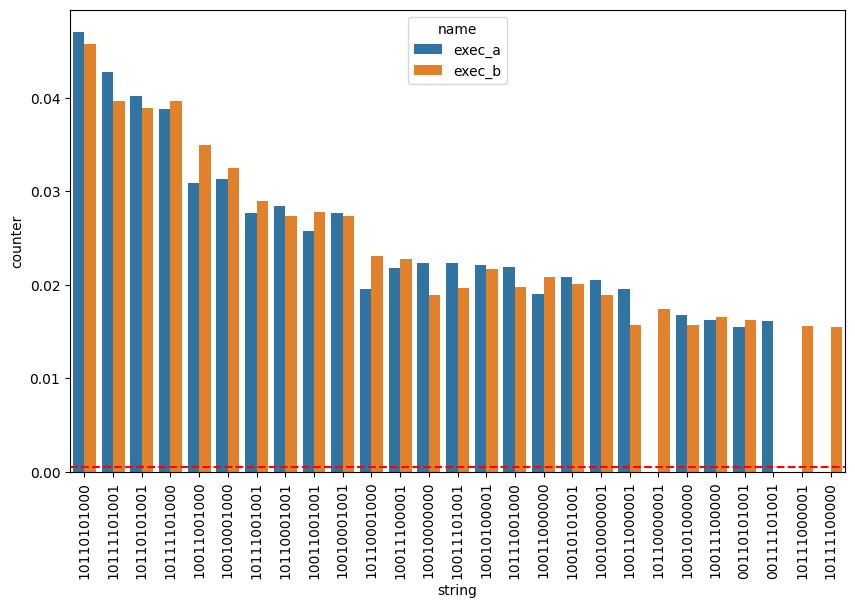

PROGRAM_ID_UNDER_ANALYSIS: 52_64cd91
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG4ZtoSS', 'ChangeBackend']
SAME RESULT (p_val > 0.5)
New p-value: 0.9999999934850193
n_qubits: 4
n_shots_platform_a: 692.0
n_shots_platform_b: 692.0
Uniform threshold: 0.0625


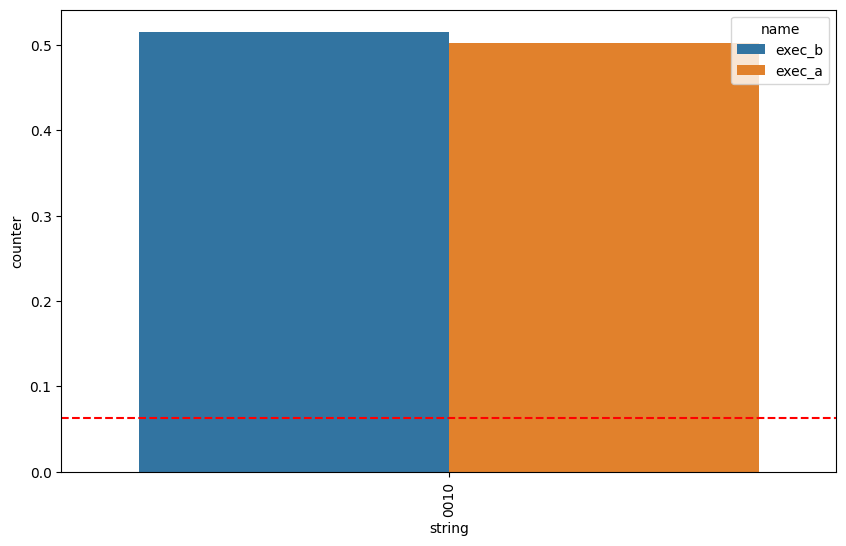

PROGRAM_ID_UNDER_ANALYSIS: 52_39cf43
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG7CCNOTDecomposition', 'ChangeOptLevel']
SAME RESULT (p_val > 0.5)
New p-value: 0.7064665690972298
n_qubits: 7
n_shots_platform_a: 1959.0
n_shots_platform_b: 1959.0
Uniform threshold: 0.0078125


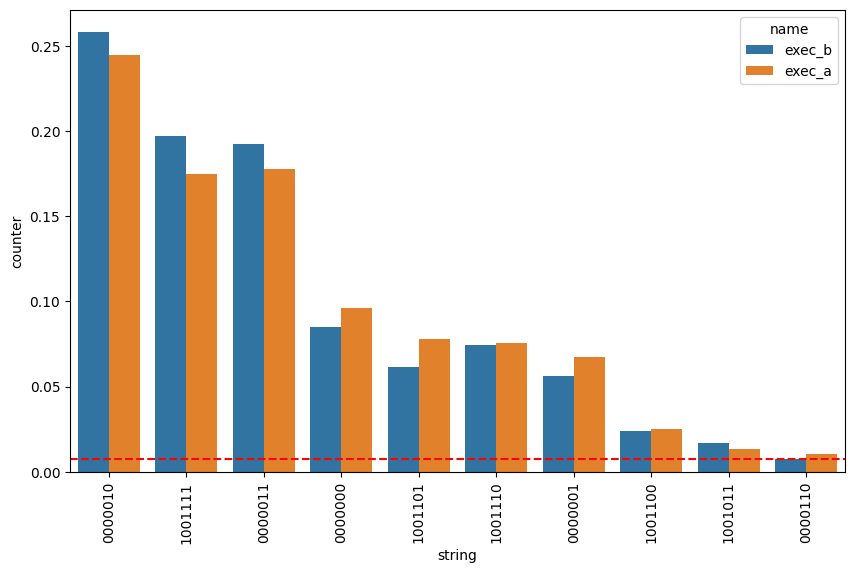

PROGRAM_ID_UNDER_ANALYSIS: 52_6affda
Exceptions from execution: {'source': None, 'followup': None}
['QdiffG4ZtoSS', 'ChangeBackend']
SAME RESULT (p_val > 0.5)
New p-value: 0.9349920789826108
n_qubits: 4
n_shots_platform_a: 692.0
n_shots_platform_b: 692.0
Uniform threshold: 0.0625


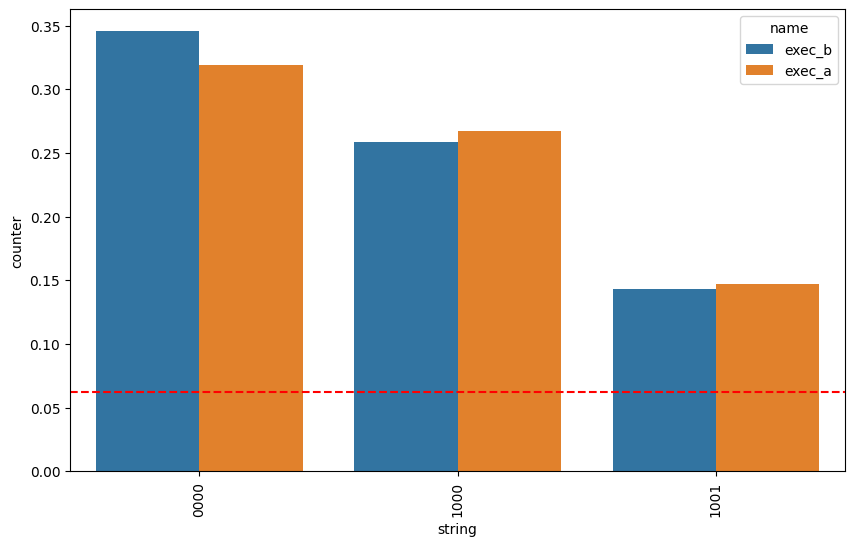

In [44]:
import random
random.seed(42)
# set numpy seed 
import numpy as np
np.random.seed(42)

for bug_folder in os.listdir(qdiff_path)[:]:
    rerun_and_plot(
        bug_folder=os.path.join(qdiff_path, bug_folder),
        exp_name="qmt_v52")


# MorphQ

PROGRAM_ID_UNDER_ANALYSIS: 53_a5856d
Exceptions from execution: {'source': None, 'followup': None}
['RunIndependentPartitions']
{1: 0, 4: 1, 0: 2, 2: 3, 3: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10}
<class 'dict'>
SAME RESULT (p_val > 0.5)
New p-value: 0.9999180824792402
n_qubits: 11
n_shots_platform_a: 7838.0
n_shots_platform_b: 7678.0
Uniform threshold: 0.00048828125


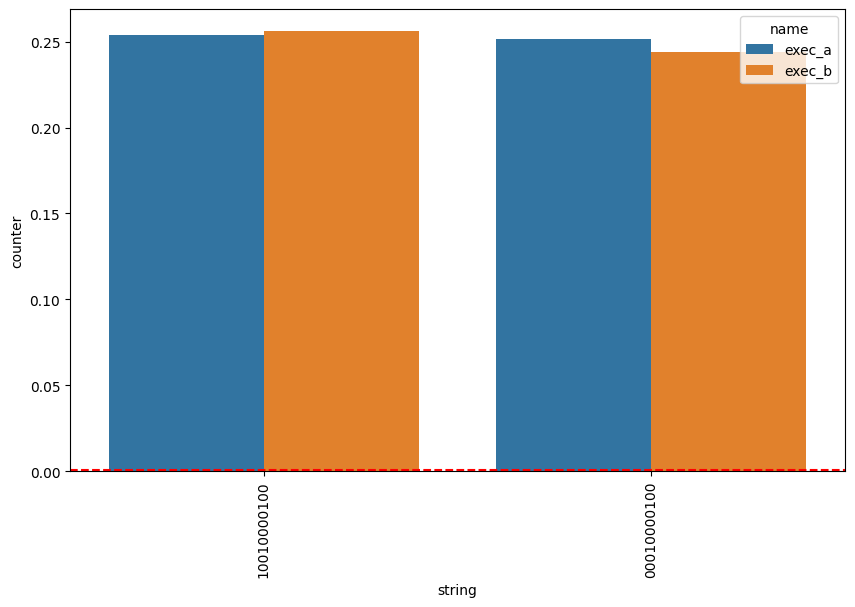

PROGRAM_ID_UNDER_ANALYSIS: 53_baa269
Exceptions from execution: {'source': None, 'followup': None}
['ChangeBackend', 'ToQasmAndBack', 'ChangeOptLevel']
SAME RESULT (p_val > 0.5)
New p-value: 0.9658727543792797
n_qubits: 8
n_shots_platform_a: 2771.0
n_shots_platform_b: 2771.0
Uniform threshold: 0.00390625


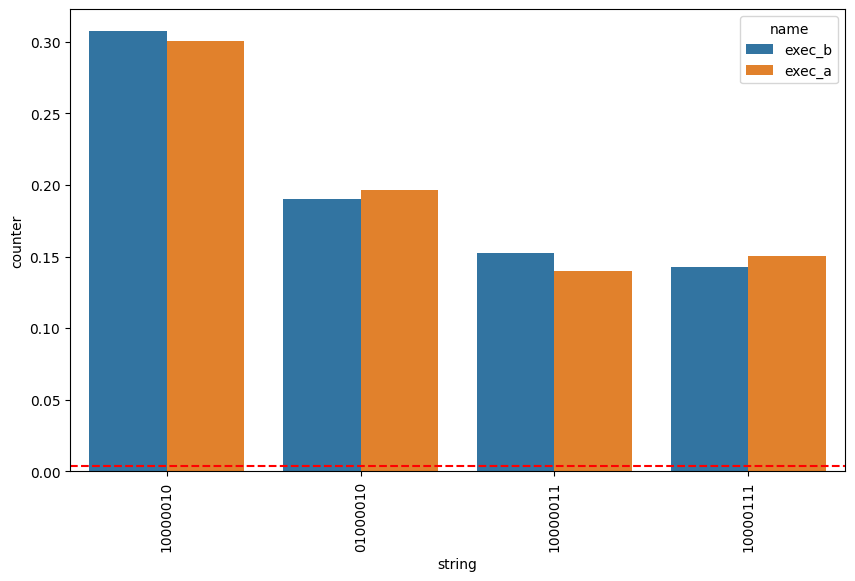

PROGRAM_ID_UNDER_ANALYSIS: 53_3c83fc
Exceptions from execution: {'source': None, 'followup': None}
['ChangeQubitOrder']
{0: 3, 1: 0, 2: 4, 3: 2, 4: 1}
<class 'str'>
SAME RESULT (p_val > 0.5)
New p-value: 0.9658592171108189
n_qubits: 5
n_shots_platform_a: 979.0
n_shots_platform_b: 979.0
Uniform threshold: 0.03125


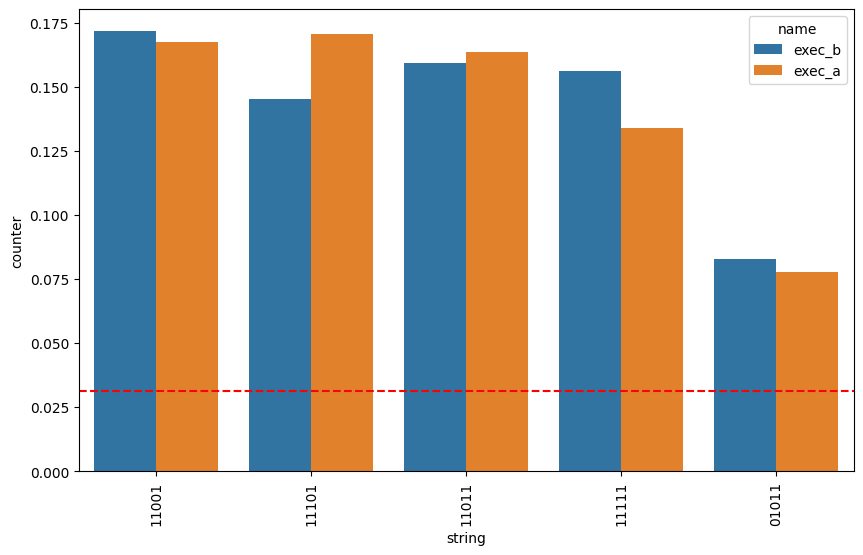

PROGRAM_ID_UNDER_ANALYSIS: 53_1c6450
Exceptions from execution: {'source': None, 'followup': None}
['AddUnusedRegister', 'ChangeOptLevel', 'RunIndependentPartitions']
{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 1: 10}
<class 'dict'>
SAME RESULT (p_val > 0.5)
New p-value: 0.9846863734232925
n_qubits: 11
n_shots_platform_a: 7838.0
n_shots_platform_b: 7680.0
Uniform threshold: 0.00048828125


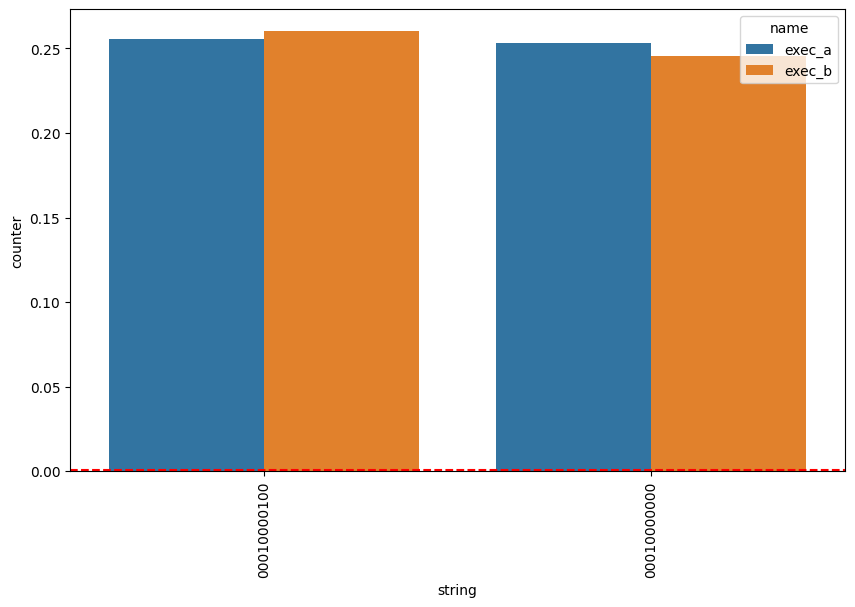

PROGRAM_ID_UNDER_ANALYSIS: 53_82ce7f
Exceptions from execution: {'source': None, 'followup': None}
['RunIndependentPartitions']
{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 1: 10}
<class 'dict'>
SAME RESULT (p_val > 0.5)
New p-value: 0.37112694495880016
n_qubits: 11
n_shots_platform_a: 7838.0
n_shots_platform_b: 7682.0
Uniform threshold: 0.00048828125


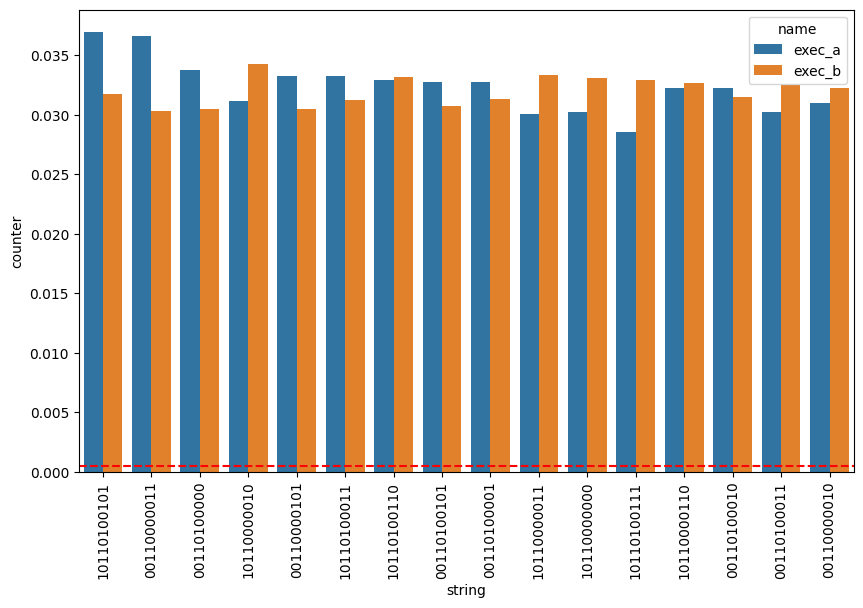

PROGRAM_ID_UNDER_ANALYSIS: 53_83317f
Exceptions from execution: {'source': None, 'followup': None}
['ChangeOptLevel', 'RunIndependentPartitions']
{0: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 10: 9, 1: 10}
<class 'dict'>
SAME RESULT (p_val > 0.5)
New p-value: 0.7855477847225679
n_qubits: 11
n_shots_platform_a: 7838.0
n_shots_platform_b: 7680.0
Uniform threshold: 0.00048828125


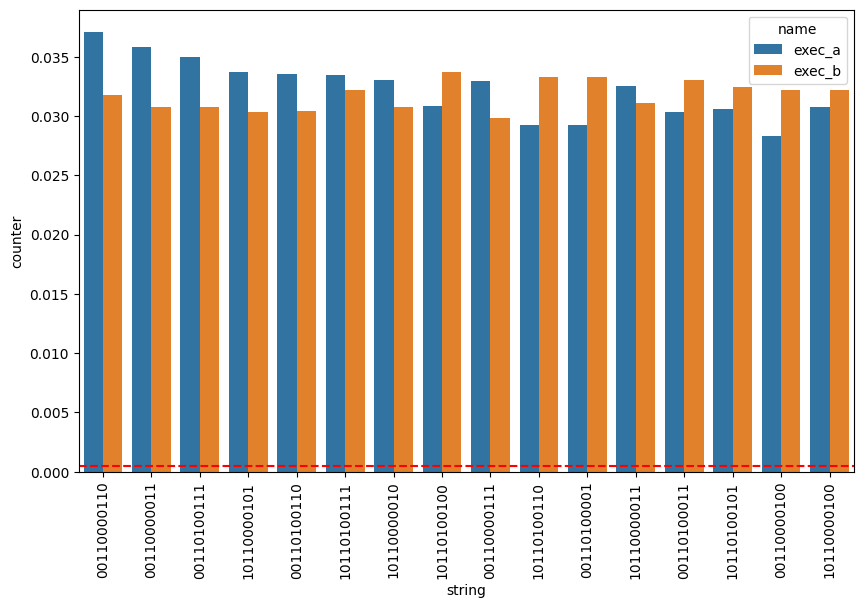

PROGRAM_ID_UNDER_ANALYSIS: 53_e05d70
Exceptions from execution: {'source': None, 'followup': None}
['ChangeCouplingMap']
SAME RESULT (p_val > 0.5)
New p-value: 0.9304612314260128
n_qubits: 5
n_shots_platform_a: 979.0
n_shots_platform_b: 979.0
Uniform threshold: 0.03125


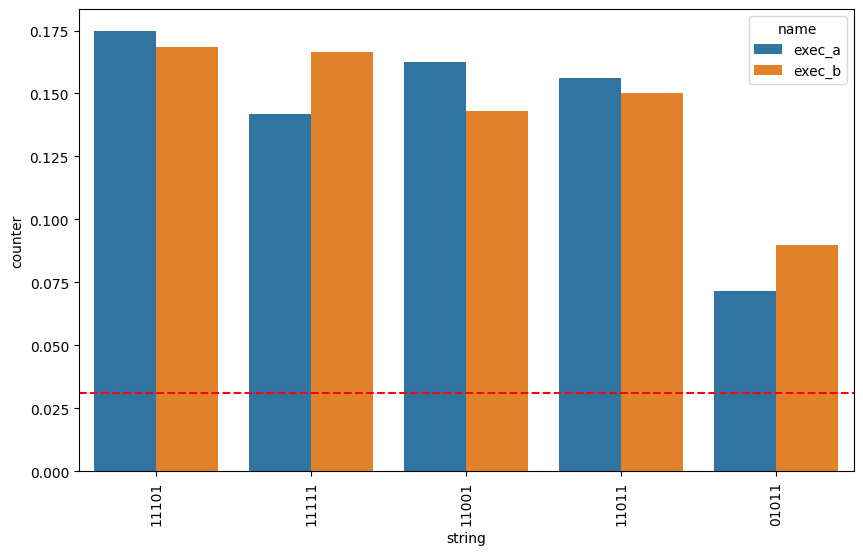

PROGRAM_ID_UNDER_ANALYSIS: 53_9762a5
Exceptions from execution: {'source': None, 'followup': None}
['RunIndependentPartitions']
{5: 0, 0: 1, 1: 2, 2: 3, 3: 4, 4: 5, 6: 6, 7: 7}
<class 'dict'>
SAME RESULT (p_val > 0.5)
New p-value: 0.9990609438494394
n_qubits: 8
n_shots_platform_a: 2771.0
n_shots_platform_b: 959.0
Uniform threshold: 0.00390625


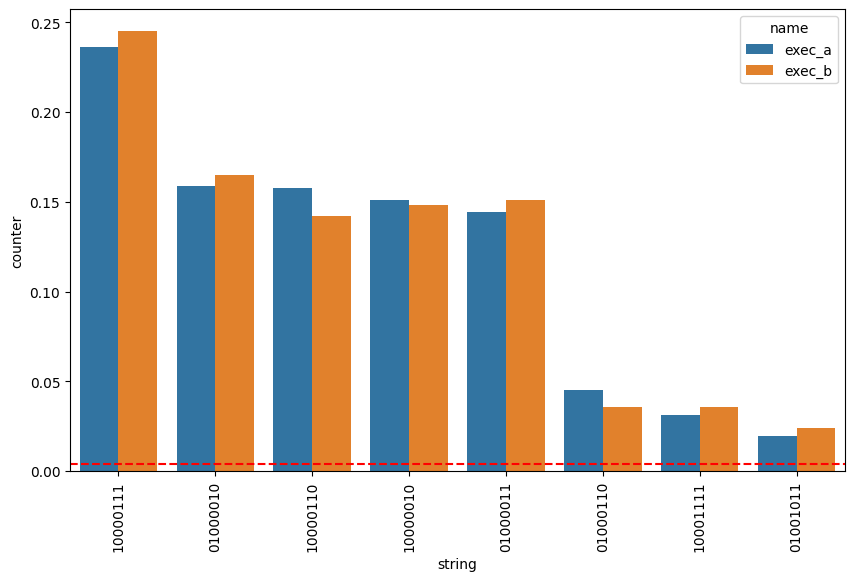

PROGRAM_ID_UNDER_ANALYSIS: 53_ea013a
Exceptions from execution: {'source': None, 'followup': None}
['ChangeQubitOrder']
{0: 0, 1: 1, 2: 2}
<class 'str'>
SAME RESULT (p_val > 0.5)
New p-value: 0.494438005631411
n_qubits: 3
n_shots_platform_a: 489.0
n_shots_platform_b: 489.0
Uniform threshold: 0.125


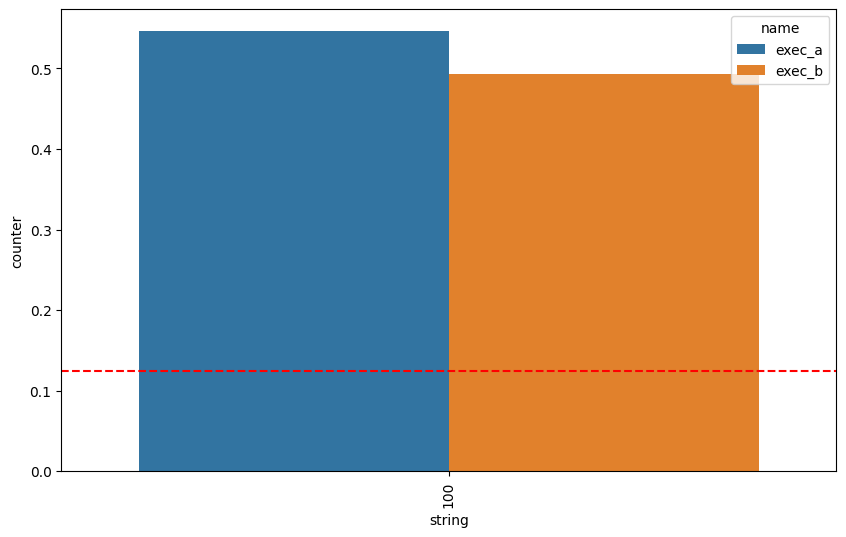

PROGRAM_ID_UNDER_ANALYSIS: 53_6a2df0
Exceptions from execution: {'source': None, 'followup': None}
['InjectParameters', 'ChangeQubitOrder']
{0: 4, 1: 6, 2: 2, 3: 0, 4: 1, 5: 3, 6: 5}
<class 'str'>
SAME RESULT (p_val > 0.5)
New p-value: 0.9999999999999999
n_qubits: 7
n_shots_platform_a: 1959.0
n_shots_platform_b: 1959.0
Uniform threshold: 0.0078125


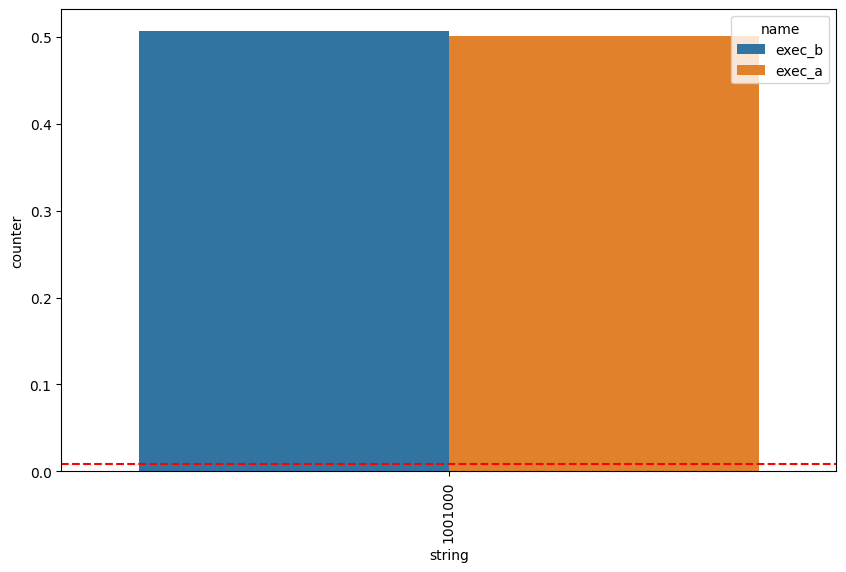

In [45]:
for bug_folder in os.listdir(morphq_path)[:]:
    rerun_and_plot(
        bug_folder=os.path.join(morphq_path, bug_folder),
        exp_name="qmt_v53")
